# L-SRTDE algorithm

Information from [original paper](https://ieeexplore.ieee.org/document/10611907)

## Features

### Rank

$rank_i=e^{-kp*i/n}$

- $kp$ is a selective pressure parameter (the selective pressure was shown to improve the convergence speed)
- $i = 1,2,...,N$

### Mutation strategy from [L-NTADE](https://www.mdpi.com/2227-7390/10/24/4666)
It`s called *r-new-to-ptop/n/t*

$u_{i,j}=x^{new}_{r_1,j} + F*(x^{top}_{pbest,j} - x^{new}_{i,j}) + F*(x^{new}_{r_2,j} - x^{top}_{r_3,j})$

- $x^{new}$ are newest solutions in iteration
- $x^{top}$ are top solutions in done iterations
- $r_1$ and $r_13$ parameters are chosen randomly
- $r_2$ is chosen with rank-based selective pressure with $kp=3$
- $pbest$ is chosen from pb% best solutions from the top population ($x^{top}$)

### Crossover strategy from [L-NTADE](https://www.mdpi.com/2227-7390/10/24/4666)

$x_{nc}=
\left\{
\begin{aligned}
  &u_i,  \textrm{if} f(u_i) \le f(x^{new}_{r_1})\\
  &x_{nc}, \textrm{if} f(u_i) > f(x^{new}_{r_1})
\end{aligned}
\right.$

- $nc$ is an index iterated after every successful replacement, if $nc>N$ then $nc=1$
- $u_i$ is the trial vector, $x^{new}_{r_1}$ is the basic vector
- if the trial vector $u_i$ is better than the basic vector $x^{new}_{r_1}$ then it replaces individual with $nc$ index, not with $i$ index
- all successful vectors are stored in temporary storage $x^{temp}$ with their fitness values
- at the end of iteration $x^{temp}$ and $x^{top}$ solutions are combined and sorted by fitness values. Then the best $N$ solutions are chosen and are placed to new $x^{top}$
- the length of $x^{top}$ must be equal to $N$

### Scaling factor adaptation for $F$ (first feature)

$mF=0.4 + 0.25*tanh(5*SR)$

- $SR=NS/N$, $NS$ is the number of successful solutions (number of times the selection worked)
- $mF$ was proposed as hyper-heuristic approach for $F$ scaling $F=randn(mF,0.02)$

### Success rate for $pb$ parameter

$pb=0.7*e^{-7*SR}$

- if the success rate $SR$ is close to 0, then $pbest$ index s chose from 70% of the best solutions
- if the success rate grows, the $pb$ decreases, and focuses on smaller number of the best solutions (the best of the best)

### Repaired crossover rate $Cr$

$Cr=randn(M_{Cr,k},0.05)$

## Pseudocode

1. Input: $D$, $NFE_max$, $N_{max}$, target function $f(x)$
2. Output: $x^{top}_best$, $f(x^{top}_best)$
3. Set $N=N_{max}$, $N_{min}=4$, $H=5$, $M_{Cr,r}=1$
4. Set $SR=0.5$, $k=1$, $g=0$, $nc=1$, $kp=3$
5. Initialize population ($x^{new}_{1,j},...,x^{new}_{N,j}$) randomly
6. Calculate $f(x^{new})$
7. Copy $x^{new}$ to $x^{top}$, $f(x^{new})$ to $f(x^{top})$
8. **while** $NFE < NFE_{max}$ **do**
    1. Set $S_{Cr}=\emptyset$, $S_{\Delta f}=\emptyset$
    2. Sort $x^{new}$ and $f(x^{new})$
    3. Assign ranks for $x^{new}$
    4. *for* $i=1$ to $N^{g}$ *do*
        1. $mF=0.4 + 0.25*th(5*SR)$
        2. **repeat**
            1. $F_i=randn(mF,0.02)$
        3. **until** $F_i \in (0,1)$
        4. Current memory index $r=randi[1,H]$
        5. Crossover rate $Cr_i=randn(M_{Cr,r},0.05)$
        6. $Cr_i=min(1,max(0,Cr))$
        7. $r_1=randi(N^g)$
        8. $pb=0.7*e^{-7*SR}$
        9. **repeat**
            1. $pbest=randi(1,1,N^g*pb)$
            2. Generate $r_2$ with rank-based selection
            3. $r_3=randi(1,N^g)$
        10. **until** indexes $r_1$, $r_2$, $r_3$ and $pbest$ are different
        11. Apply mutation to produce $u_i$ with $F_i$
        12. Apply binomial crossover to produce $u_i$ with $Cr_i$
        13. Calculate actual rater $Cr_a$
        14. Apply bound constraint handling method
        15. Calculate $f(u_i)$
        16. **if** $f(u_i) < f(x^{new}_{r_1})$ **then**
            1. $Cr_a \rightarrow S_{Cr}$
            2. $(f(x^{new}_{r_1})-f(u_i)) \rightarrow S_{\Delta f} $
            3. $u_i \rightarrow x^{temp}$
            4. $f(x^{temp}_m) = f(u_i)$
            5. $x^{new}_{nc}=u_i$
            6. $f(x^{new}_{nc}) = f(u_i)$
            7. $nc=mod(nc+1, N^{g}), m = m + 1$
        17. **end if**
    5. **end for**
    6. Get $N^{g+1} with LPSR$
    7. Join together $x^{top}$ and $x^{temp}$ and sort
    8. Copy $N^{g+1}$ best vectors back to $x^{top}$
    9. **if** $N^{g} > N^{g+1}$ **then**
        1. Remove worst individuals from $x^{new}$
    10. **end if**
    11. Update $M_{Cr,k}$
    12. $k=mod(k+1,H), g=g+1, m=1$
9. **end while**
10. Return $x^{top}_{best}, f(x^{top}_{best})$

## Python implementation
with russian comments

In [1]:
import random
from typing import List, Callable

import numpy as np

class AlgorithmConst:
    """
    Константы для алгоритма.
    
    Аттрибуты:
        records_number_per_function: 
            количество точек данных, сохраненных в массиве результатов, для построения кривой сходимости.
        global_seed: глобальный seed для всех генераторов.
        seed1,...,seed4: seed-ы для генераторов.
    """
    records_number_per_function = 1001
    global_seed = 2025
    seed1 = global_seed
    seed2 = global_seed + 100
    seed3 = global_seed + 200
    seed4 = global_seed + 300
    
    
class AlgorithmGLobals:
    """
    Глобальные переменные для алгоритма.
    
    Аттрибуты:
        eval_steps: 
            массив контрольных значений оценки,
            в котором будет храниться ошибка оптимизации.
        results_array: хранит значения отклонения от оптимума (ошибки).
        last_eval_step: счетчик для хранения последнего шага оценки.
        eval_func_calls: счетчик для хранения количества текущих вызовов целевой функции.
        max_eval_func_calls: максимальное количество вызовов целевой функции (ограничение).
        problem_dimension: размерность задачи.
        eval_func_opt_value: оптимальное значение целевой функции.
        global_best: наилучшее значение целевой функции, найденное глобально (в текущей итерации).
        global_best_init: булевый флаг для инициализации global_best.
    """
    eval_steps = np.zeros(AlgorithmConst.records_number_per_function - 1)
    results_array = np.zeros(AlgorithmConst.records_number_per_function)
    last_eval_step = 0
    eval_func_calls = 0
    max_eval_func_calls = 0
    problem_dimension = 30
    eval_func_opt_value = 0.0
    global_best = 0.0
    global_best_init = False
    

class AlgorithmRandomGenerators:
    """Класс, реализующий генераторы."""
    def __init__(self, seeds: List[int]):
        self.generators = []
        if len(seeds) < 4:
            raise ValueError
        for i, seed in enumerate(seeds):
            self.generators.append(np.random.default_rng(seed=seed))
    
    def random_integers(self, low: int, high: int, size: int):
        """Возвращает случайное целое число в указанном интервале."""
        return self.generators[0].integers(low=low, high=high, size=size)
    
    def random_floats(self):
        """Возвращает число с плавающей запятой в интервале от 0 до 1."""
        return self.generators[1].random(size=1)[0]
    
    def random_normal(self, size: int = 1):
        """ВОзращает случайное число с плавающей запятой в нормальном распределении."""
        return self.generators[2].normal(size=size)
    
    def alt_random_integers(self, low: int, high: int, size: int):
        """Возвращает случайное целое число в указанном интервале. Ещё один."""
        return self.generators[3].integers(low=low, high=high, size=size)
    
random_generator = AlgorithmRandomGenerators(seeds=[
    AlgorithmConst.seed1,
    AlgorithmConst.seed2,
    AlgorithmConst.seed3,
    AlgorithmConst.seed4
])


def quick_sort_with_indices(
    array: np.ndarray, 
    left: int = 0, right: 
    int = None, 
    indices: np.ndarray = None
):
    """Быстрая сортировка на месте с соответствующим отслеживанием индекса."""
    if right is None:
        right = len(array) - 1
    if indices is None:
        indices = np.arange(len(array))

    if len(array) == 0 or right < left:
        return array, indices

    i = left
    j = right
    pivot = float(array[(left + right) // 2])

    while i <= j:
        while array[i] < pivot:
            i += 1
        while array[j] > pivot:
            j -= 1
        if i <= j:
            array[i], array[j] = array[j], array[i]
            indices[i], indices[j] = indices[j], indices[i]
            i += 1
            j -= 1

    if left < j:
        quick_sort_with_indices(array, left, j, indices)
    if i < right:
        quick_sort_with_indices(array, i, right, indices)

    return array, indices


class Algorithm:
    _consts = AlgorithmConst()
    _global_variables = AlgorithmGLobals()
    _random_generators = AlgorithmRandomGenerators(seeds=[
        _consts.seed1,
        _consts.seed2,
        _consts.seed3,
        _consts.seed4
    ])
    
    """Python-имплементация L-STRDE алгоритма."""
    def __init__(self, fitness_function: Callable, verbose: bool = True):
        self.verbose = verbose
        
        # Целевая функция
        self.fitness_function = fitness_function
        
        # Счетчики и локальные переменные
        
        # Память для параметров ДЭ
        self.memory_size = 5
        self.memory_iter = 0
        self.memory_index = 0
        # Количество успешных решений в итерации
        self.success_filled = 0
        # Размерность пространства решений
        self.n_vars = 0
        # Размер текущей популяции
        self.n_inds_current = 0
        # Размер фронтовой части популяции
        self.n_inds_front = 0
        # Максимальный размер фронтовой части популяции
        self.n_inds_front_max = 0
        # Новый размер фронтовой части популяции
        self.new_n_inds_front = 0
        # Размер популяции
        self.population_size = 0
        # Индекс индивида, выбранного для мутации
        self.chosen_index = 0
        # Номер текущего поколения
        self.iter_number = 0
        # Индекс в фронтовой части, куда записывается новая успешная особь.
        self.pf_index = 0
        # Наилучшее значение целевой функции
        self.best_fitness_value = 0.0
        # Доля успешных мутаций
        self.success_rate = 0.5
        # Параметры ДЭ
        self.F = 0.0
        self.Cr = 0.0
        # Верхняя граница для решения
        self.right = 0.0
        # Нижняя граница для решения
        self.left = 0.0
        
        # Списки
        self.population = []
        self.front_population = []
        self.temp_population = []
        self.fitness_func_values = [] 
        self.fitness_func_values_copy = []
        self.fitness_func_values_front = []
        # Пробное решение (индивид)
        self.trial_solution = []
        # Значения параметра Cr для успешных пробных особей в текущей итерации
        self.temp_success_Cr = []
        # Исторические значения Cr — память об успешных итерациях
        self.Cr_memory = []
        # Разница между старыми и новыми значениями целевой функции
        self.fitness_values_dif = []
        # Используются как веса для адаптации Cr
        self.weights = []
        
        # Индексы популяций
        self.indices = []
        self.indices2 = []
        
    def initialize(
        self, 
        new_n_inds: int,
        new_n_vars: int, 
    ):
        """Инициализация всех структур и параметров, необходимых для запуска алгоритма."""
        self.n_vars = new_n_vars
        self.n_inds_current = new_n_inds
        self.n_inds_front = new_n_inds
        self.n_inds_front_max = new_n_inds
        self.population_size = new_n_inds * 2
        self.left = -100
        self.right = 100
        self.iter_number = 0
        self.chosen_index = 0
        self.memory_size = 5
        self.memory_iter = 0
        self.success_filled = 0
        self.success_rate = 0.5
        
        # Подготовка шагов оценки
        self._global_variables.eval_steps = [
            10000.0 / (
                self._consts.records_number_per_function - 1
            ) * self.n_vars * (steps_k + 1)
            for steps_k in range(self._consts.records_number_per_function - 1)
        ]
    
        # Инициализация списков
        # Популяция
        self.population = np.zeros((self.population_size, self.n_vars))
        self.front_population = np.zeros((self.n_inds_front, self.n_vars))  
        self.temp_population = np.zeros((self.population_size, self.n_vars))
        # Значения целевой функции
        self.fitness_func_values = np.zeros(self.population_size)
        self.fitness_func_values_copy = np.zeros(self.population_size)
        self.fitness_func_values_front = np.zeros(self.n_inds_front)                     
        # Параметры алгоритма
        self.weights = np.zeros(self.population_size)
        self.temp_success_Cr = np.zeros(self.population_size)
        self.fitness_values_dif = np.zeros(self.population_size)
        self.Cr_memory = np.ones(self.memory_size)
        self.trial_solution = np.zeros(self.n_vars)
        self.indices = np.zeros(self.population_size, dtype=int)
        self.indices2 = np.zeros(self.population_size, dtype=int)
        
        # Генерация начальной популяции                          
        for i in range(self.population_size):
            for j in range(self.n_vars):
                self.population[i][j] = np.random.uniform(self.left, self.right)
                                   
    def update_Cr_memory(self):
        """
        Функция отвечает за адаптацию параметра кроссовера (Cr)
        на основе успешных значений, найденных в текущем поколении.
        """
        if self.success_filled != 0:
            self.Cr_memory[self.memory_iter] += 0.5 * self.mean_wl(
                self.temp_success_Cr, self.fitness_values_dif
            )
            self.memory_iter = (self.memory_iter + 1) % self.memory_size
                                   
    def mean_wl(
        self, 
        array: np.ndarray, 
        temp_weights: np.ndarray
    ) -> float:
        """
        Функция возвращает адаптивное значение Cr, 
        основанное на успешных значениях Cr
        из предыдущего поколения, с учетом того, 
        насколько они улучшили результат.
        """
        sum_weight = 0
        sum_square = 0
        _sum = 0
        weights = np.empty(self.success_filled)
        
        for i in range(self.success_filled):
            sum_weight += temp_weights[i]
                                   
        for i in range(self.success_filled):
            if sum_weight == 0 or np.isnan(sum_weight):
                weights[i] = 0
            else:
                weights[i] = temp_weights[i] / sum_weight
                                   
        for i in range(self.success_filled):
            sum_square += weights[i]*np.power(array[i], 2)
            _sum += weights[i]*array[i]

        if abs(_sum) > 1e-8:
            return sum_square/_sum
        else:
            return 1.0
        
    def find_n_save_best(self, init, ind_iter):
        """
        Функция обновляет локальные 
        и глобальные лучшие значения целевой функции.
        """
        if self.fitness_func_values[ind_iter] <= self.best_fitness_value or init:
            self.best_fitness_value = self.fitness_func_values[ind_iter]
        if self.best_fitness_value < self._global_variables.global_best or init:
            self._global_variables.global_best = self.best_fitness_value

    def save_best_values(self):
        """
        Функция предназначена для сохранения сходимости
        траектории алгоритма оптимизации.
        """
        temp = self._global_variables.global_best - self._global_variables.eval_func_opt_value
        if temp <= 1e-8 \
            and self._global_variables.results_array[
                self._consts.records_number_per_function - 1
        ] == self._global_variables.max_eval_func_calls:
            self._global_variables.results_array[
                self._consts.records_number_per_function - 1
            ] = self._global_variables.eval_func_calls
        
        for step_eval_func_count in range(
            self._global_variables.last_eval_step, 
            self._consts.records_number_per_function - 1):
            if self._global_variables.eval_func_calls == self._global_variables.eval_steps[
                step_eval_func_count
            ]:
                if temp <= 1e-8:
                    temp = 0
                self._global_variables.results_array[step_eval_func_count] = temp
                self._global_variables.last_eval_step = step_eval_func_count

    def remove_worst(self, _n_inds_front: int, new_n_inds_front: int):
        """
        Удаление худших особей из популяции
        по значению целевой функции.
        """
        points_to_remove = _n_inds_front - new_n_inds_front

        for l in range(points_to_remove):
            worst_fit = self.fitness_func_values_front[0]
            worst_num = 0;
            for i in range(1, _n_inds_front):
                if (self.fitness_func_values_front[i] > worst_fit):
                    worst_fit = self.fitness_func_values_front[i]
                    worst_num = i

            for i in range(worst_num, _n_inds_front-1):
                for j in range(self.n_vars):
                    self.front_population[i][j] = self.front_population[i+1][j]
                self.fitness_func_values_front[i] = self.fitness_func_values_front[i+1]
        return _n_inds_front
    
    @staticmethod
    def create_component_selector(fit_temp2):
        """
        Функция создает функцию-генератор, которая возвращает
        один индекс, выбранный случайным образом с учетом весов.
        """
        def selector():
            return random.choices(range(len(fit_temp2)), weights=fit_temp2, k=1)[0]
        return selector
    
    def main_cycle(self):
        """Запуск алгоритма L-SRTDE."""
        fitness_temp2 = []
        
        # Инициализация fitness значений для стартовой популяции
        for i_inds in range(self.n_inds_front):
            self.fitness_func_values[i_inds] = self.fitness_function(self.population[i_inds])
            self._global_variables.eval_func_calls += 1
            self.find_n_save_best(i_inds == 0, i_inds)

            if (not self._global_variables.global_best_init
                or self.best_fitness_value < self._global_variables.global_best):
                self._global_variables.global_best = self.best_fitness_value
                self._global_variables.global_best_init = True

            self.save_best_values()
        
        # Копирование занчений целевых функций и индексов
        # Определение мин/макс целевой функции
        for i in range(self.n_inds_front):
            self.fitness_func_values_copy[i] = self.fitness_func_values[i].copy()
            self.indices[i] = i
            
        min_fitness_value = np.min(self.fitness_func_values[:self.n_inds_front])
        max_fitness_value = np.max(self.fitness_func_values[:self.n_inds_front])

        # Сортировка и обновление фронтовой части популяции
        if min_fitness_value != max_fitness_value:
            self.fitness_func_values_copy, self.indices = quick_sort_with_indices(
                array=self.fitness_func_values_copy,
                indices=self.indices,
                left=0,
                right=self.n_inds_front - 1,
            )

        # Обновляем фронтовую часть популяции согласно сортировке
        for i in range(self.n_inds_front):
            self.front_population[i] = self.population[self.indices[i]].copy()
            self.fitness_func_values_front[i] = self.fitness_func_values_copy[i]

        self.pf_index = 0

        # Главный цикл алгоритма
        while self._global_variables.eval_func_calls < self._global_variables.max_eval_func_calls:
            
            _max_calls = self._global_variables.max_eval_func_calls
            _current_calls = self._global_variables.eval_func_calls
            
            if self.verbose:
                print(
                    f'--- Iteration {self.iter_number}, '
                    f'left {_max_calls-_current_calls} calls, '
                    f'current best fitness value: {self._global_variables.global_best}'
                )
            
            # Расчет параметров
            mean_F = 0.4 + np.tanh(self.success_rate * 5) * 0.25
            sigma_F = 0.02

            # Копируем и сортируем значения целевой функции для всей популяции            
            for i in range(self.n_inds_front):
                self.fitness_func_values_copy[i] = self.fitness_func_values[i]
                self.indices[i] = i
            
            min_fitness_value = np.min(self.fitness_func_values[:self.n_inds_front])
            max_fitness_value = np.max(self.fitness_func_values[:self.n_inds_front])

            if min_fitness_value != max_fitness_value:
                self.fitness_func_values_copy, self.indices = quick_sort_with_indices(
                    array=self.fitness_func_values_copy,
                    indices=self.indices,
                    left=0,
                    right=self.n_inds_front - 1,
                )

            # Аналогично сортируем значения целевой функции для фронтовой части популяции            
            for i in range(self.n_inds_front):
                self.fitness_func_values_copy[i] = self.fitness_func_values_front[i]
                self.indices2[i] = i
            
            min_fitness_value = np.min(self.fitness_func_values_front[:self.n_inds_front])
            max_fitness_value = np.max(self.fitness_func_values_front[:self.n_inds_front])
            
            if min_fitness_value != max_fitness_value:
                self.fitness_func_values_copy, self.indices2 = quick_sort_with_indices(
                    array=self.fitness_func_values_copy,
                    indices=self.indices2,
                    left=0,
                    right=self.n_inds_front - 1,
                )

            # Весовой вектор для выбора
            fitness_temp2 = np.empty(self.n_inds_front)
            for i in range(self.n_inds_front):
                fitness_temp2[i] = np.exp(-i/self.n_inds_front*3)
            component_selector_front = self.create_component_selector(fitness_temp2)

            p_size_val = max(2, int(self.n_inds_front * 0.7 * np.exp(-self.success_rate * 7)))
            
            # Итерируемся по фронтовой части популяции
            for i_ind in range(self.n_inds_front):
                
                # Выбираем индекс из фронтовой части популяции
                self.chosen_index = random.randint(0, self.n_inds_front - 1)
                
                # Выбираем индекс из памяти
                self.memory_index = random.randint(0, self.memory_size - 1)

                # Выбор p_rand, не равного индексу выбранного индивида
                p_rand = self.indices[random.randint(0, p_size_val - 1)]
                while p_rand == self.chosen_index:
                    p_rand = self.indices[random.randint(0, p_size_val - 1)]

                # Выбор Rand1, не равного p_rand
                Rand1 = self.indices2[component_selector_front()]
                while Rand1 == p_rand:
                    Rand1 = self.indices2[component_selector_front()]

                # Выбор Rand2, не равного p_rand и Rand1
                Rand2 = self.indices[random.randint(0, self.n_inds_front - 1)]
                while Rand2 == p_rand or Rand2 == Rand1:
                    Rand2 = self.indices[random.randint(0, self.n_inds_front - 1)]

                # Генерация F и Cr с ограничениями
                # Параметр мутации F
                self.F = np.random.normal(mean_F, sigma_F)
                while self.F < 0.0 or self.F > 1.0:
                    self.F = np.random.normal(mean_F, sigma_F)
                
                # Параметр кроссовера Cr из памяти
                self.Cr = np.random.normal(self.Cr_memory[self.memory_index], 0.05)
                # Ограничиваем Cr диапазоном [0, 1]
                self.Cr = min(max(self.Cr, 0.0), 1.0)
                actual_Cr = 0
                Will_crossover = random.randint(0, self.n_vars - 1)
                
                # Создаем массив для пробного решения
                self.trial_solution = np.zeros(self.n_vars)

                for j in range(self.n_vars):
                    if self._random_generators.random_floats() < self.Cr or Will_crossover == j:
                        val = (self.front_population[self.chosen_index][j]
                               + self.F * (self.population[p_rand][j] 
                                           - self.front_population[self.chosen_index][j])
                               + self.F * (self.front_population[Rand1][j] - self.population[Rand2][j]))

                        if val < self.left or val > self.right:
                            val = random.uniform(self.left, self.right)

                        self.trial_solution[j] = val
                        actual_Cr += 1
                    else:
                        self.trial_solution[j] = self.front_population[self.chosen_index][j]

                actual_Cr /= float(self.n_vars)
                
                # Считаем значение целевой функции для пробного решения
                temp_fit = self.fitness_function(self.trial_solution)
                self._global_variables.eval_func_calls += 1

                if temp_fit <= self.fitness_func_values_front[self.chosen_index]:
                    # Если улучшение найдено
                    idx = self.n_inds_front + self.success_filled
                    self.population[idx] = self.trial_solution.copy()
                    self.front_population[self.pf_index] = self.trial_solution.copy()
                    self.fitness_func_values[idx] = temp_fit
                    self.fitness_func_values_front[self.pf_index] = temp_fit
                    # Обновляем лучшее решение
                    self.find_n_save_best(False, idx)
                    # Сохраняем Cr
                    self.temp_success_Cr[self.success_filled] = actual_Cr
                    self.fitness_values_dif[self.success_filled] = abs(
                        self.fitness_func_values_front[self.chosen_index] - temp_fit
                    )

                    self.success_filled += 1
                    # Сдвигаем индекс pf_index
                    self.pf_index = (self.pf_index + 1) % self.n_inds_front

                self.save_best_values()

            # Вычисляем процент успешных мутаций
            self.success_rate = float(self.success_filled) / float(self.n_inds_front)

            # Вычисляем новый размер фронтовой части популяции
            self.new_n_inds_front = int(
                (4 - self.n_inds_front_max) / self._global_variables.max_eval_func_calls 
                * self._global_variables.eval_func_calls
                + self.n_inds_front_max
            )
            # Удаляем худшие решения из фронтовой части популяции
            self.remove_worst(self.n_inds_front, self.new_n_inds_front)
            # Обновляем размер фронтовой части популяции
            self.n_inds_front = self.new_n_inds_front
            # Обновляем память Cr
            self.update_Cr_memory()
            # Обновляем текущий размер популяции
            self.n_inds_current = self.n_inds_front + self.success_filled
            # Обнуляем количество успешных мутаций
            self.success_filled = 0
            # Увеличиваем счетчик поколений
            self.iter_number += 1

            # Коррекция популяции, если она увеличилась
            if self.n_inds_current > self.n_inds_front:
                for i in range(self.n_inds_current):
                    self.indices[i] = i

                min_fitness_value = np.min(self.fitness_func_values[:self.n_inds_current])
                max_fitness_value = np.max(self.fitness_func_values[:self.n_inds_current])

                if min_fitness_value != max_fitness_value:
                    self.fitness_func_values, self.indices = quick_sort_with_indices(
                        array=self.fitness_func_values,
                        indices=self.indices,
                        left=0,
                        right=self.n_inds_current - 1,
                    )

                self.n_inds_current = self.n_inds_front

                for i in range(self.n_inds_current):
                    self.temp_population[i] = self.population[self.indices[i]].copy()
                    self.population[i] = self.temp_population[i].copy()

### Load GNBG class

In [2]:
import os
_root_path = os.getcwd()
os.chdir('..')
from _gnbg_functions.gnbg import GNBG
os.chdir(_root_path)

### Run and visualize

In [3]:
import time
import traceback

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Настройки
total_n_runs = 1
max_n_funcs = 24
population_size = 10

In [4]:
# Результаты всех запусков
res = np.zeros((max_n_funcs, total_n_runs, 1001))

# Запуск алгоритма и сбор результатов
for func_num in range(1, max_n_funcs + 1):
    try:
        gnbg = GNBG(func_num)
        fopt = gnbg.opt_value

        for run in range(total_n_runs):
            t0 = time.time()
            print(f"Running algorithm on {gnbg}, run {run + 1}")
            optz = Algorithm(gnbg.Fitness, False)
            optz._global_variables.global_best_init = False
            optz._global_variables.last_eval_step = 0
            optz._global_variables.eval_func_calls = 0
            optz._global_variables.max_eval_func_calls = gnbg.max_evals
            optz._global_variables.results_array[
                optz._consts.records_number_per_function - 1
            ] = gnbg.max_evals / 100

            optz.initialize(
                new_n_inds=population_size * gnbg.dimension,
                new_n_vars=gnbg.dimension,
            )
            optz.main_cycle()
            res[func_num - 1, run] = optz._global_variables.results_array
            print(f'\tElapsed time: {round(time.time()-t0, 2)} sec')
    except Exception as e:
        print(f'\t### Error in function {func_num}: {e}')
        print(f'\t### Traceback: {traceback.format_exc()}')

Running algorithm on GNBG Function 1 (D=30), run 1
	Elapsed time: 51.21 sec
Running algorithm on GNBG Function 2 (D=30), run 1
	Elapsed time: 56.0 sec
Running algorithm on GNBG Function 3 (D=30), run 1
	Elapsed time: 51.17 sec
Running algorithm on GNBG Function 4 (D=30), run 1
	Elapsed time: 51.15 sec
Running algorithm on GNBG Function 5 (D=30), run 1
	Elapsed time: 50.96 sec
Running algorithm on GNBG Function 6 (D=30), run 1
	Elapsed time: 52.41 sec
Running algorithm on GNBG Function 7 (D=30), run 1
	Elapsed time: 55.44 sec
Running algorithm on GNBG Function 8 (D=30), run 1
	Elapsed time: 54.83 sec
Running algorithm on GNBG Function 9 (D=30), run 1
	Elapsed time: 54.54 sec
Running algorithm on GNBG Function 10 (D=30), run 1
	Elapsed time: 54.69 sec
Running algorithm on GNBG Function 11 (D=30), run 1
	Elapsed time: 54.54 sec
Running algorithm on GNBG Function 12 (D=30), run 1
	Elapsed time: 55.32 sec
Running algorithm on GNBG Function 13 (D=30), run 1
	Elapsed time: 56.01 sec
Running a

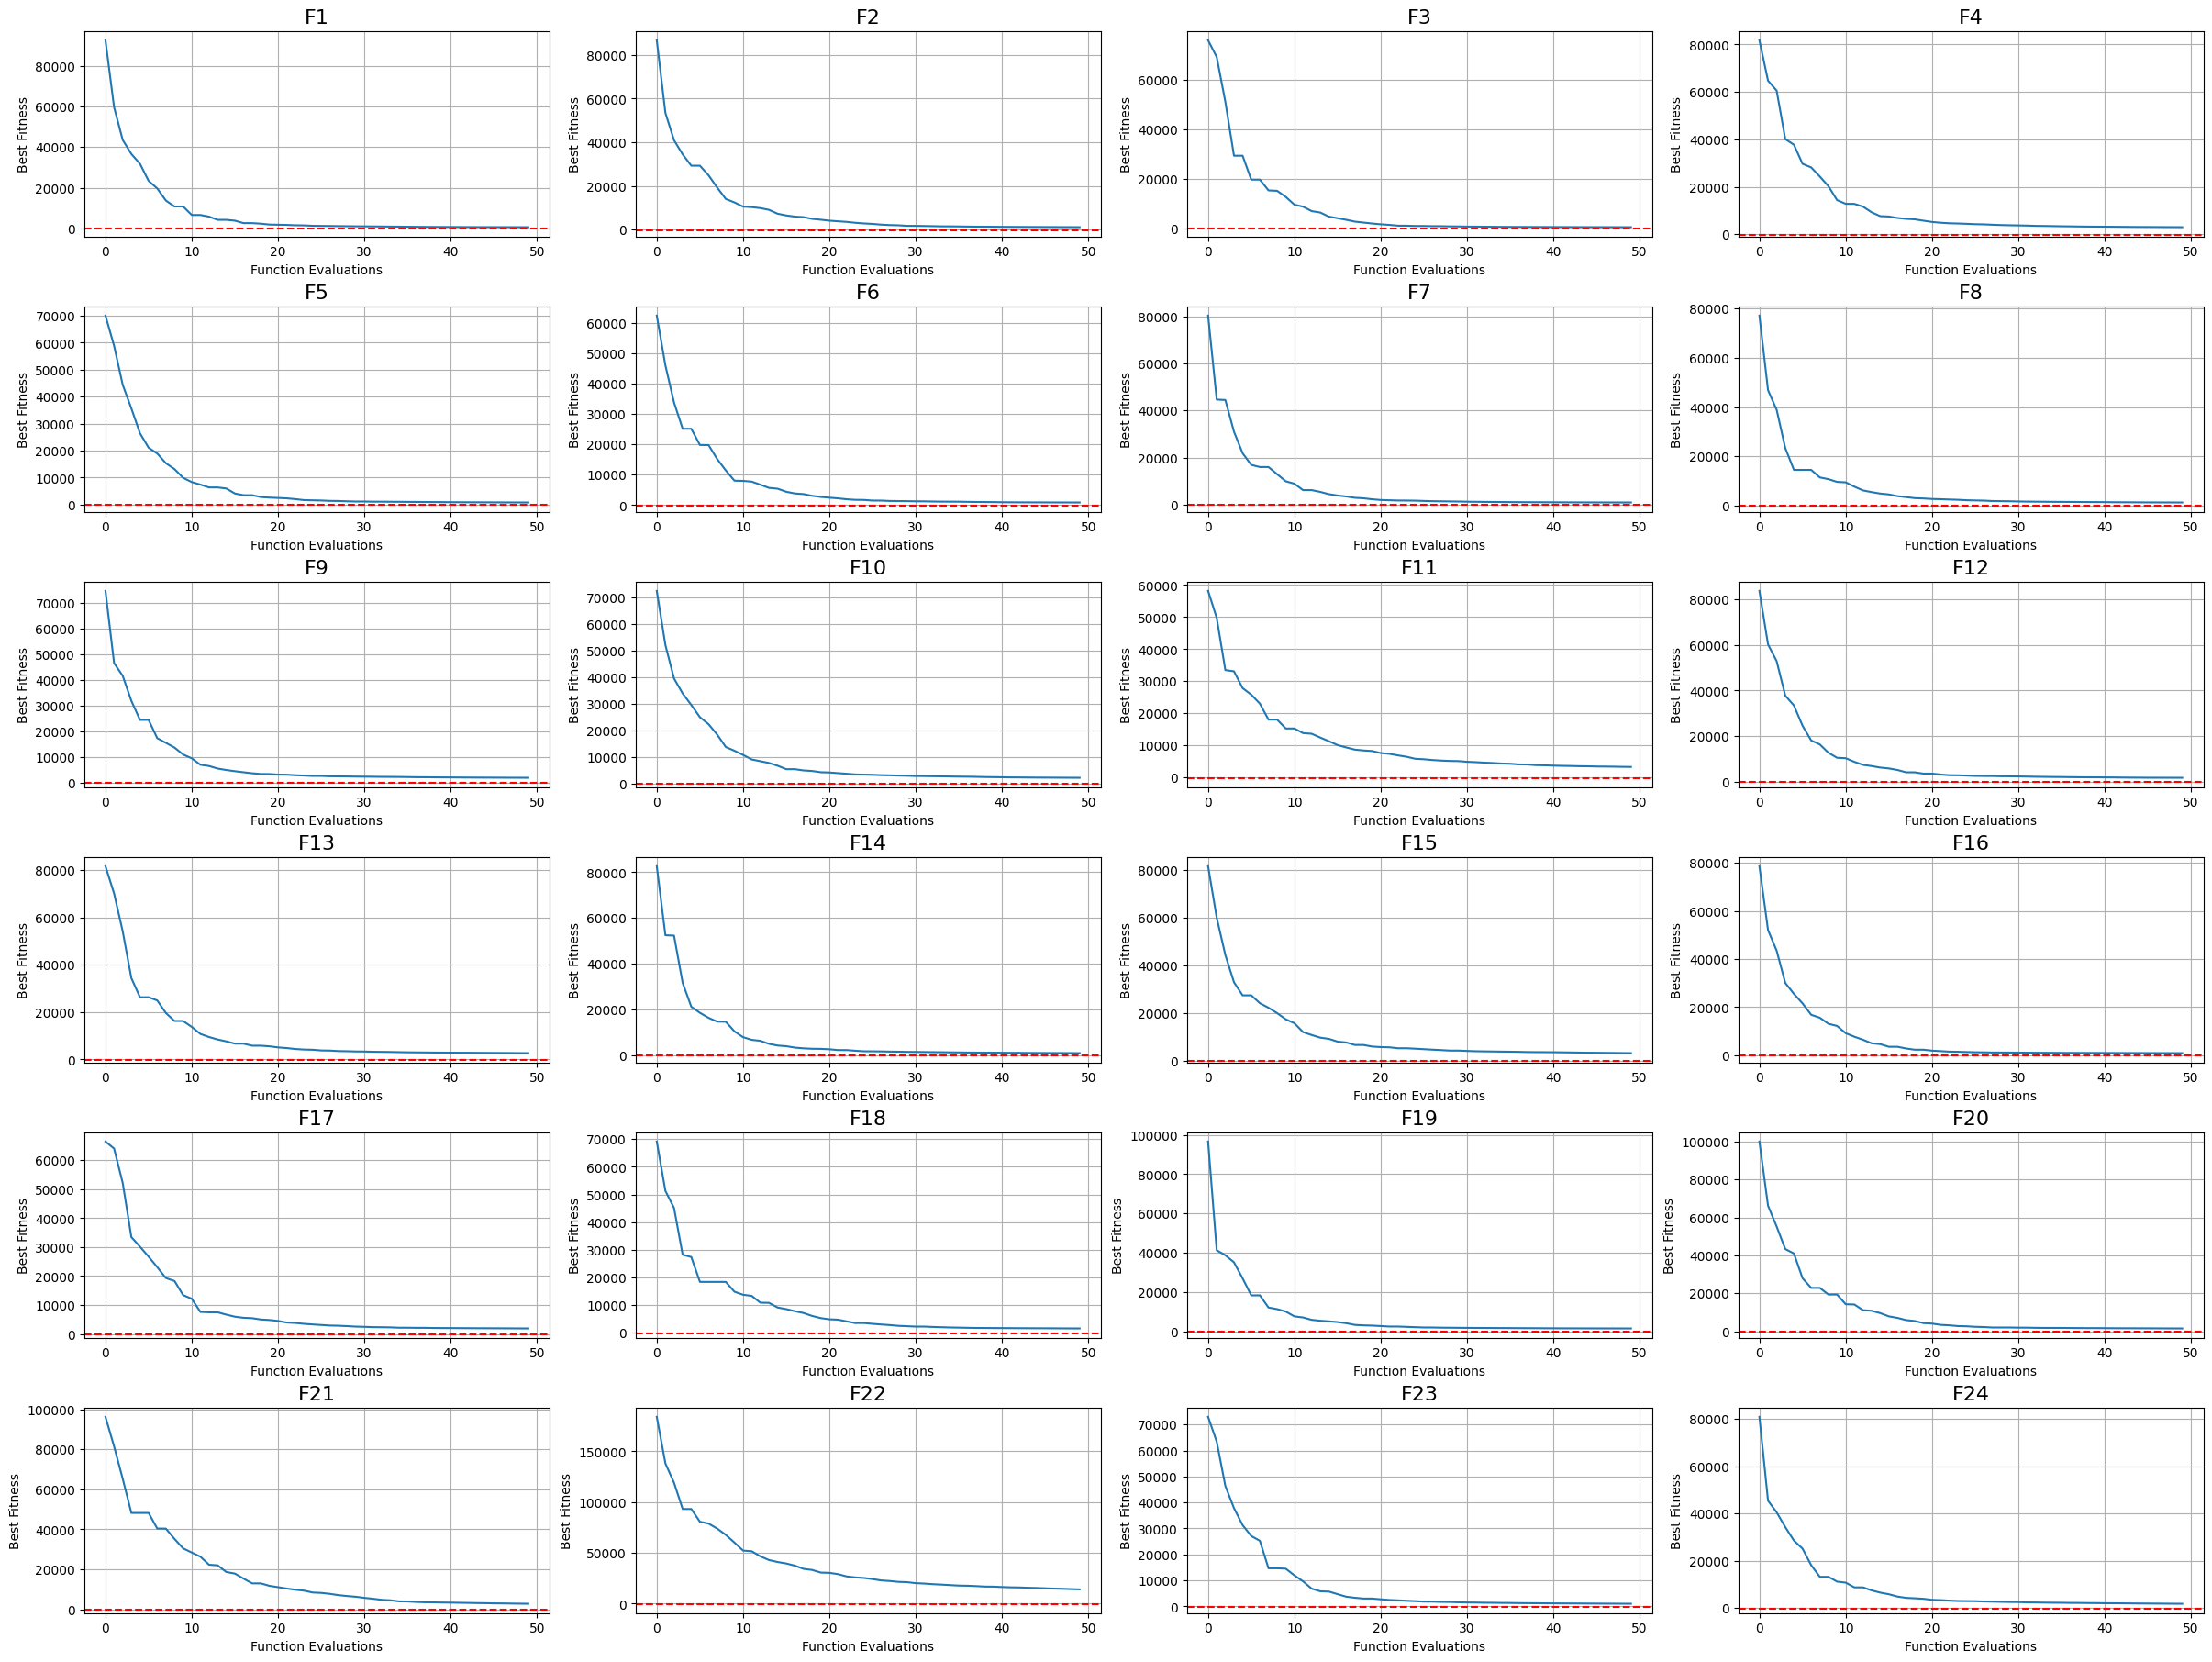

In [12]:
is_need_log = False

fig = plt.figure(figsize=(24, 18), constrained_layout=True)
gs = fig.add_gridspec(6, 4)
limit = 50

# Визуализация
for func_num in range(1, max_n_funcs + 1):
    row = (func_num - 1) // 4
    col = (func_num - 1) % 4
    ax = fig.add_subplot(gs[row, col])
    for run in range(total_n_runs):
        if is_need_log:
            ax.semilogy(res[func_num - 1, run, :limit], label=f"Run {run+1}")
        else:
            ax.plot(res[func_num - 1, run, :limit], label=f"Run {run+1}")
    ax.set_title(f"F{func_num}", fontsize=16)
    ax.set_xlabel("Function Evaluations")
    ax.set_ylabel("Best Fitness")
    
    ax.axhline(y=fopt, color='red', linestyle='--')
    
    ax.grid(True)

plt.savefig('python_l_strde_on_gnbg.png')
plt.show()

### Original Results

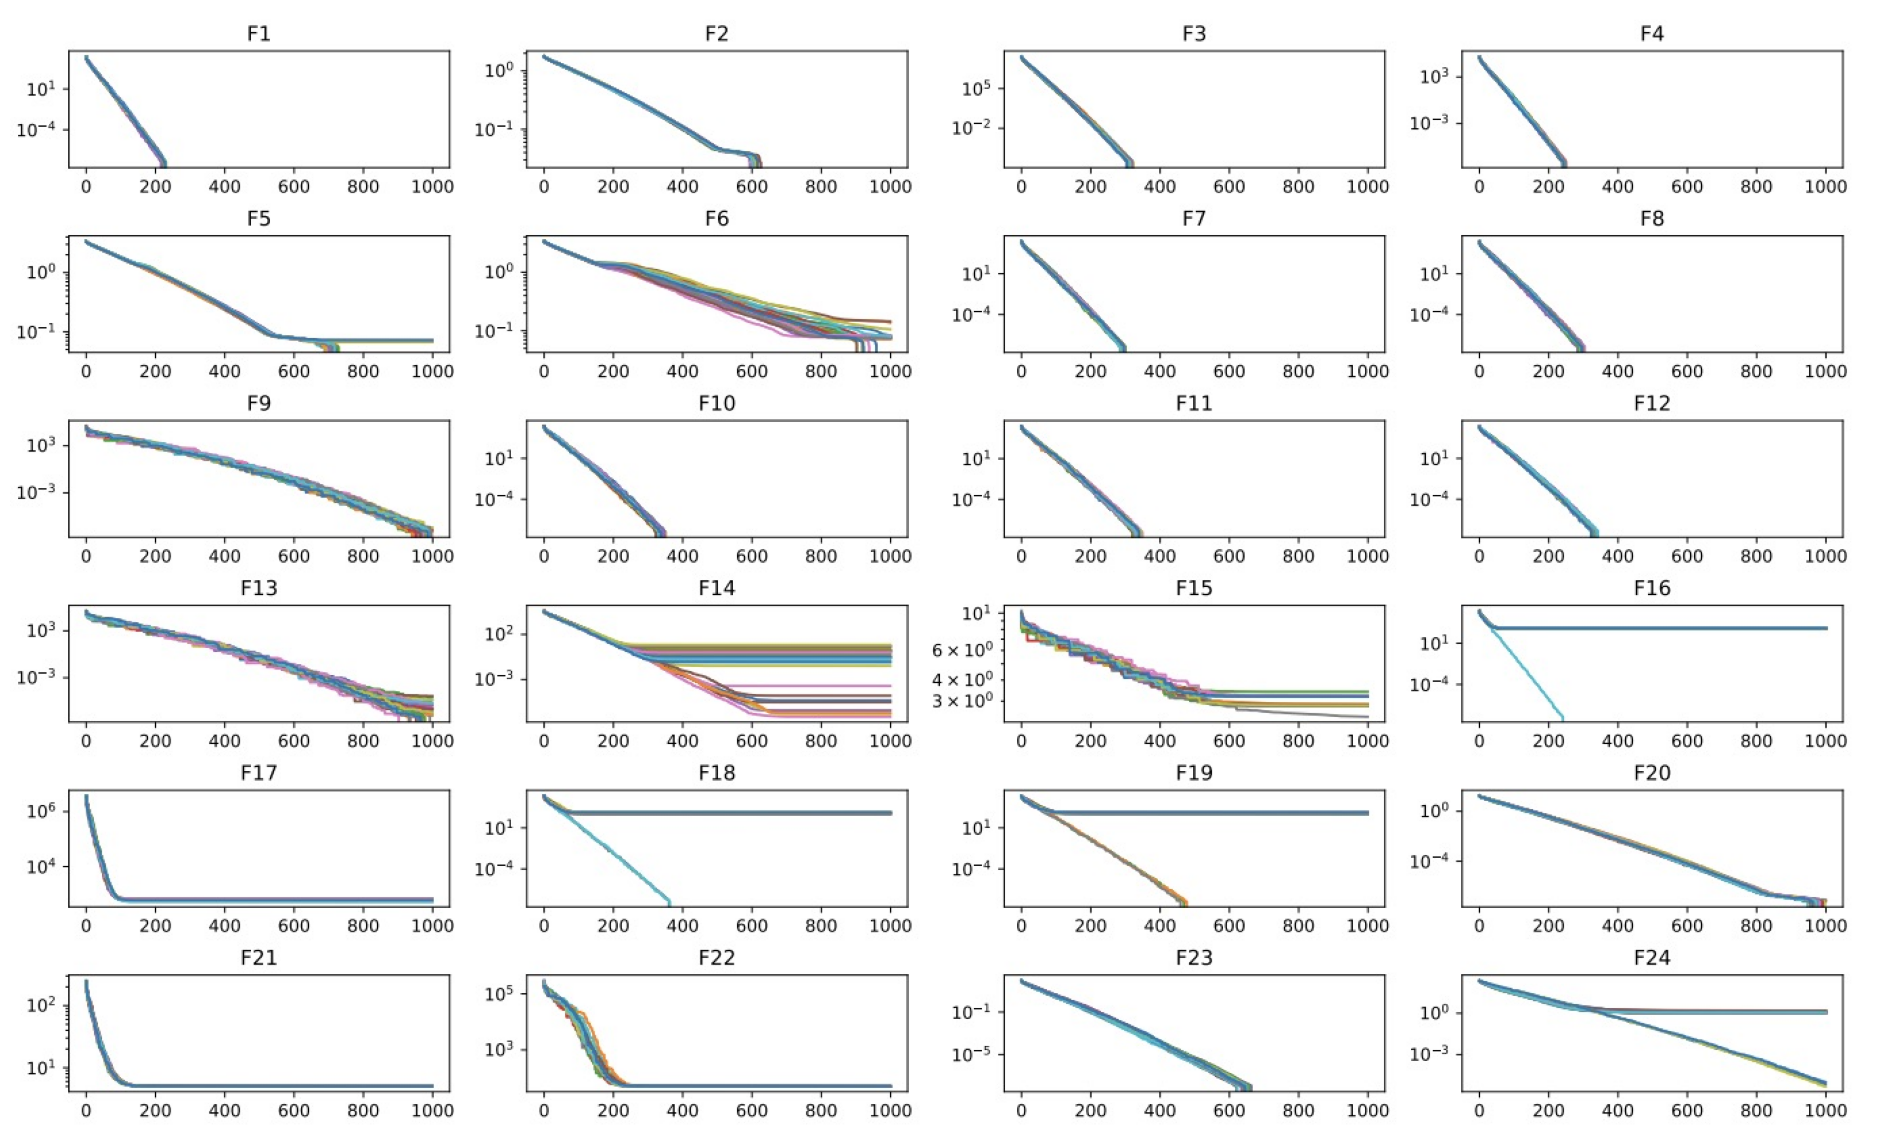

In [6]:
from PIL import Image

image = Image.open('l_strde_on_gnbg.jpeg')
image_np = image.convert('RGB')
plt.figure(figsize=(24, 18))
plt.imshow(image_np)
plt.axis('off')
plt.show()

### Table of results

In [7]:
import copy
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

res_table = pd.DataFrame(columns=[
    'Function', 'Absolute error', 
    'Required function evaluations to acceptance threshold',
    'Success rate'
])

row_tamplate = {
    'Function': None,
    'Absolute error': None,
    'Required function evaluations to acceptance threshold': None,
    'Success rate': None
}

for func_i in range(max_n_funcs):
    _row = copy.deepcopy(row_tamplate)
    _row['Function'] = f'F{func_i+1}'
    _row['Absolute error'] = str(round(np.mean(res[func_i,:,-2]), 6)) \
        + u"\u00B1" + str(round(np.std(res[func_i,:,-2]), 6))

    _row['Required function evaluations to acceptance threshold'] = str(round(np.mean(res[func_i,:,-1]), 6)) \
        + u"\u00B1" + str(round(np.std(res[func_i,:,-1]), 6))
    
    success_rate = 0
    for run_i in range(total_n_runs):
        success_rate += (res[func_i,run_i,-2] == 0)
    success_rate /= total_n_runs
    _row['Success rate'] = success_rate
    
    res_table = pd.concat([res_table, pd.DataFrame([_row])], axis=0, ignore_index=True)
    
res_table

,Function,Absolute error,Required function evaluations to acceptance threshold,Success rate
0,F1,455.093757±0.0,5000.0±0.0,0.0
1,F2,913.368554±0.0,5000.0±0.0,0.0
2,F3,447.826283±0.0,5000.0±0.0,0.0
3,F4,2861.607686±0.0,5000.0±0.0,0.0
4,F5,724.234224±0.0,5000.0±0.0,0.0
5,F6,788.138374±0.0,5000.0±0.0,0.0
6,F7,811.944656±0.0,5000.0±0.0,0.0
7,F8,1043.110279±0.0,5000.0±0.0,0.0
8,F9,1675.505709±0.0,5000.0±0.0,0.0
9,F10,1988.857856±0.0,5000.0±0.0,0.0
